In [47]:
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

import cv2
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, SubsetRandomSampler, Dataset
from PIL import Image, ImageFile
import numpy as np
import random
import math

ImageFile.ImageFile.LOAD_TRUNCATED_IMAGES = True

In [48]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if str(device) == "cuda":
    print("Using GPU")
else:
    print("Falling back to CPU")

Falling back to CPU


In [49]:
dataset_path = os.path.join(os.getcwd(), 'dataset')
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')
val_path = os.path.join(dataset_path, 'valid')

In [50]:
print(f"""Train Dataset Path: {train_path},
Test Dataset Path: {test_path},
Validation Dataset Path: {val_path}
""")

Train Dataset Path: c:\Users\zain4\GitProjects\WildFire-Classification-Through-Images\dataset\train,
Test Dataset Path: c:\Users\zain4\GitProjects\WildFire-Classification-Through-Images\dataset\test,
Validation Dataset Path: c:\Users\zain4\GitProjects\WildFire-Classification-Through-Images\dataset\valid



In [51]:
class WildfireDataset(Dataset):
    def __init__(self, dir, num_images_per_class, img_size):

        self.dir = dir
        self.num_images_per_class = num_images_per_class
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),  
            # transforms.CenterCrop(img_size),  
            transforms.ToTensor(),  
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        self.wildfire_dir = os.path.join(dir, "wildfire")
        self.nowildfire_dir = os.path.join(dir, "nowildfire")

        self.image_paths = []
        self.labels = []

        for class_dir in [self.wildfire_dir, self.nowildfire_dir]:
            filenames = os.listdir(class_dir)
            if len(filenames) > self.num_images_per_class:
                selected_filenames = random.sample(filenames, self.num_images_per_class)
            else:
                selected_filenames = filenames
            for filename in selected_filenames:
                image_path = os.path.join(class_dir, filename)
                self.image_paths.append(image_path)
                self.labels.append(0 if class_dir == self.nowildfire_dir else 1)
        self.shuffle_data()

    def shuffle_data(self):
        combined = list(zip(self.image_paths, self.labels))
        random.shuffle(combined)
        self.image_paths[:], self.labels[:] = zip(*combined)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # print(self.image_paths[idx])
        image_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(image_path).convert('RGB') 
        image = self.transform(image)

        #image.show()
        
        return image, label


In [52]:
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.CenterCrop((128, 128)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [53]:
# train_dataset = datasets.ImageFolder(train_path, transform)
# test_dataset = datasets.ImageFolder(test_path, transform)
# valid_dataset = datasets.ImageFolder(val_path, transform)

In [54]:
# train_sampler = SubsetRandomSampler(list(range(1000)) + list(range(1000)))
# test_sampler = SubsetRandomSampler(list(range(300)) + list(range(300)))
# val_sampler = SubsetRandomSampler(list(range(300)) + list(range(300)))

In [55]:
# train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler)
# valid_loader = DataLoader(valid_dataset, batch_size=32, sampler=test_sampler)
# test_loader = DataLoader(test_dataset, batch_size=32, sampler=val_sampler)

In [56]:
train_dataset = WildfireDataset(train_path, 1000, 224)
test_dataset = WildfireDataset(test_path, 300, 224)
valid_dataset = WildfireDataset(val_path, 300, 224)

In [57]:
train_loader = DataLoader(train_dataset, batch_size=32)
valid_loader = DataLoader(valid_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [58]:
class CNNModel1(nn.Module):
    def __init__(self):
        super(CNNModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.fc3 = nn.Linear(128, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.drouput = nn.Dropout(0.1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drouput(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drouput(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drouput(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drouput(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

In [59]:
class CNNModel2(nn.Module):
    def __init__(self):
        super(CNNModel2, self).__init__()
#         224, 224, 3 -- > (3, 224, 224)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.fc = nn.Linear(512 * 7 * 7, 64)
        self.fc1 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.bn1(x)
        x = self.maxpool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = self.maxpool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.bn3(x)
        x = self.maxpool(x)
        
        x = self.conv4(x)
        x = self.relu(x)
        x = self.bn4(x)
        x = self.maxpool(x)
        
        x = self.conv5(x)
        x = self.relu(x)
        x = self.bn5(x)
        x = self.maxpool(x)
        
        x = self.avgpool(x) # 2D shape until here
        x = torch.flatten(x, 1) # (n, 512, 7, 7) --> (n, 512*7*7)
        x = self.fc(x)
        x = self.relu(x)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [60]:
class CNNModel3(nn.Module):
    def __init__(self):
        super(CNNModel3, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, 3, padding=1)
        self.conv2 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 16, 3, padding=1)
        self.fc1 = nn.Linear(16 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.drouput = nn.Dropout(0.1)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.drouput(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

In [61]:
class CNNModel4(nn.Module):
    def __init__(self):
        super(CNNModel4, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.2)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x


In [62]:
class CNNModel5(nn.Module):
    def __init__(self):
        super(CNNModel5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.fc1 = nn.Linear(256 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(0.3)
        self.avgpool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.conv4(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout(x)

        x = self.avgpool(x)

        x = torch.flatten(x, 1)

        x = self.fc1(x)
        x = self.relu(x)

        x = self.fc2(x)
        x = self.relu(x)

        x = self.fc3(x)
        x = self.sigmoid(x)
        
        return x

In [63]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_acc = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1, 1))
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * images.size(0)
            # running_acc += ((outputs > 0.5).float() == labels).float().mean()
        train_loss = running_loss / len(train_loader.dataset)
        # train_acc = running_acc / math.ceil(len(train_loader.dataset) / train_loader.batch_size)
        train_losses.append(train_loss)
        # train_accs.append(train_acc)
        
        model.eval()
        running_loss = 0.0
        running_acc = 0.0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.float().reshape(-1, 1))
            running_loss += loss.item() * images.size(0)
            # running_acc += ((outputs > 0.5).float() == labels).float().mean()
        val_loss = running_loss / len(val_loader.dataset)
        # val_acc = running_acc / math.ceil(len(val_loader.dataset) / val_loader.batch_size)
        val_losses.append(val_loss)
        # val_accs.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses

In [64]:
model1 = CNNModel1().to(device)
from torchsummary import summary
summary(model1, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
           Dropout-4         [-1, 16, 112, 112]               0
            Conv2d-5         [-1, 32, 112, 112]           4,640
              ReLU-6         [-1, 32, 112, 112]               0
         MaxPool2d-7           [-1, 32, 56, 56]               0
           Dropout-8           [-1, 32, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          18,496
             ReLU-10           [-1, 64, 56, 56]               0
        MaxPool2d-11           [-1, 64, 28, 28]               0
          Dropout-12           [-1, 64, 28, 28]               0
           Conv2d-13          [-1, 128, 28, 28]          73,856
             ReLU-14          [-1, 128,

In [65]:
model2 = CNNModel2().to(device)
from torchsummary import summary
summary(model2, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
       BatchNorm2d-3         [-1, 64, 224, 224]             128
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
              ReLU-6        [-1, 128, 112, 112]               0
       BatchNorm2d-7        [-1, 128, 112, 112]             256
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
             ReLU-10          [-1, 256, 56, 56]               0
      BatchNorm2d-11          [-1, 256, 56, 56]             512
        MaxPool2d-12          [-1, 256, 28, 28]               0
           Conv2d-13          [-1, 512, 28, 28]       1,180,160
             ReLU-14          [-1, 512,

In [66]:
model3 = CNNModel3().to(device)
from torchsummary import summary
summary(model3, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 128, 224, 224]           3,584
              ReLU-2        [-1, 128, 224, 224]               0
         MaxPool2d-3        [-1, 128, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          73,792
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7           [-1, 32, 56, 56]          18,464
              ReLU-8           [-1, 32, 56, 56]               0
         MaxPool2d-9           [-1, 32, 28, 28]               0
           Conv2d-10           [-1, 16, 28, 28]           4,624
             ReLU-11           [-1, 16, 28, 28]               0
        MaxPool2d-12           [-1, 16, 14, 14]               0
          Dropout-13           [-1, 16, 14, 14]               0
        AvgPool2d-14             [-1, 1

In [67]:
model4 = CNNModel4().to(device)
from torchsummary import summary
summary(model4, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
         MaxPool2d-3         [-1, 64, 112, 112]               0
            Conv2d-4        [-1, 128, 112, 112]          73,856
              ReLU-5        [-1, 128, 112, 112]               0
         MaxPool2d-6          [-1, 128, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          73,792
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Conv2d-10           [-1, 32, 28, 28]          18,464
             ReLU-11           [-1, 32, 28, 28]               0
        MaxPool2d-12           [-1, 32, 14, 14]               0
          Dropout-13           [-1, 32, 14, 14]               0
        AvgPool2d-14             [-1, 3

In [68]:
model5 = CNNModel5().to(device)
from torchsummary import summary
summary(model5, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
              ReLU-2         [-1, 32, 224, 224]               0
         MaxPool2d-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 64, 112, 112]          18,496
              ReLU-5         [-1, 64, 112, 112]               0
         MaxPool2d-6           [-1, 64, 56, 56]               0
            Conv2d-7          [-1, 128, 56, 56]          73,856
              ReLU-8          [-1, 128, 56, 56]               0
         MaxPool2d-9          [-1, 128, 28, 28]               0
           Conv2d-10          [-1, 256, 28, 28]         295,168
             ReLU-11          [-1, 256, 28, 28]               0
        MaxPool2d-12          [-1, 256, 14, 14]               0
          Dropout-13          [-1, 256, 14, 14]               0
        AvgPool2d-14            [-1, 25

In [69]:
num_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.SGD(model1.parameters(), lr=0.01)
train_losses, val_losses = train(model1, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6920, Val Loss: 0.6930
Epoch [2/10], Train Loss: 0.6896, Val Loss: 0.6913
Epoch [3/10], Train Loss: 0.6852, Val Loss: 0.6872
Epoch [4/10], Train Loss: 0.6771, Val Loss: 0.6781
Epoch [5/10], Train Loss: 0.6628, Val Loss: 0.6595
Epoch [6/10], Train Loss: 0.6351, Val Loss: 0.6184
Epoch [7/10], Train Loss: 0.5744, Val Loss: 0.5218
Epoch [8/10], Train Loss: 0.4535, Val Loss: 0.3701
Epoch [9/10], Train Loss: 0.3429, Val Loss: 0.3044
Epoch [10/10], Train Loss: 0.3074, Val Loss: 0.2870


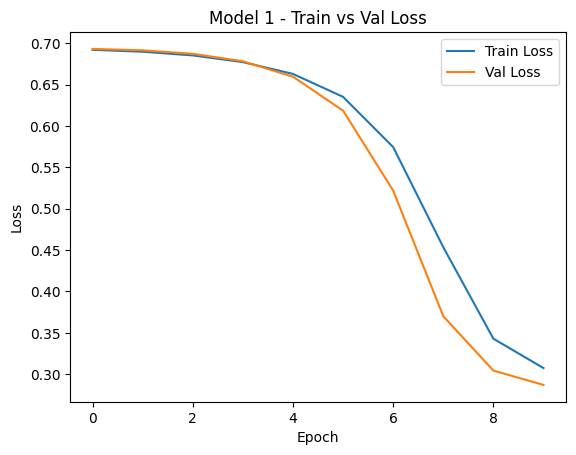

In [70]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 1 - Train vs Val Loss')
plt.show()

In [71]:
num_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01)
train_losses, val_losses = train(model2, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.2412, Val Loss: 0.2420
Epoch [2/10], Train Loss: 0.1361, Val Loss: 0.1910
Epoch [3/10], Train Loss: 0.0791, Val Loss: 0.2906
Epoch [4/10], Train Loss: 0.0410, Val Loss: 0.1895
Epoch [5/10], Train Loss: 0.0191, Val Loss: 0.1743
Epoch [6/10], Train Loss: 0.0098, Val Loss: 0.1890
Epoch [7/10], Train Loss: 0.0052, Val Loss: 0.1751
Epoch [8/10], Train Loss: 0.0042, Val Loss: 0.1727
Epoch [9/10], Train Loss: 0.0027, Val Loss: 0.1714
Epoch [10/10], Train Loss: 0.0018, Val Loss: 0.1682


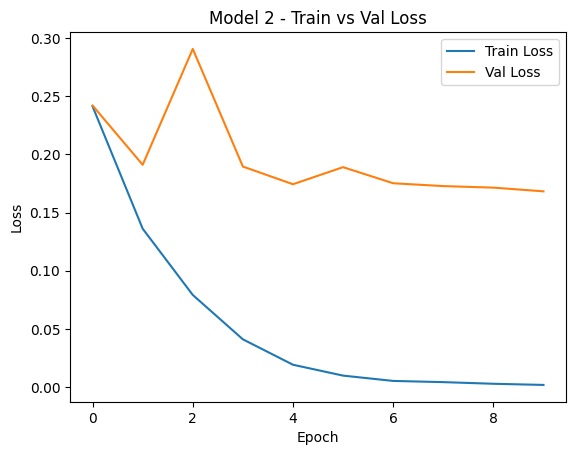

In [72]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 2 - Train vs Val Loss')
plt.show()

In [73]:
num_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.SGD(model3.parameters(), lr=0.01)
train_losses, val_losses = train(model3, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6944, Val Loss: 0.6941
Epoch [2/10], Train Loss: 0.6940, Val Loss: 0.6937
Epoch [3/10], Train Loss: 0.6936, Val Loss: 0.6934
Epoch [4/10], Train Loss: 0.6934, Val Loss: 0.6932
Epoch [5/10], Train Loss: 0.6931, Val Loss: 0.6930
Epoch [6/10], Train Loss: 0.6929, Val Loss: 0.6927
Epoch [7/10], Train Loss: 0.6927, Val Loss: 0.6924
Epoch [8/10], Train Loss: 0.6924, Val Loss: 0.6921
Epoch [9/10], Train Loss: 0.6920, Val Loss: 0.6917
Epoch [10/10], Train Loss: 0.6916, Val Loss: 0.6912


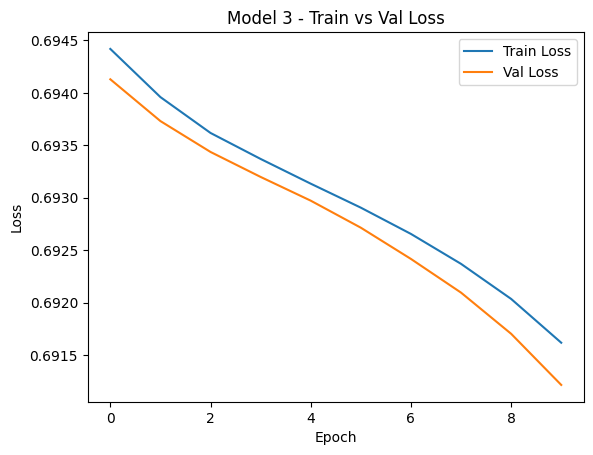

In [74]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 3 - Train vs Val Loss')
plt.show()

In [75]:
num_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.SGD(model4.parameters(), lr=0.01)
train_losses, val_losses = train(model4, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6949, Val Loss: 0.6942
Epoch [2/10], Train Loss: 0.6938, Val Loss: 0.6931
Epoch [3/10], Train Loss: 0.6928, Val Loss: 0.6920
Epoch [4/10], Train Loss: 0.6916, Val Loss: 0.6907
Epoch [5/10], Train Loss: 0.6901, Val Loss: 0.6888
Epoch [6/10], Train Loss: 0.6881, Val Loss: 0.6862
Epoch [7/10], Train Loss: 0.6851, Val Loss: 0.6823
Epoch [8/10], Train Loss: 0.6804, Val Loss: 0.6758
Epoch [9/10], Train Loss: 0.6720, Val Loss: 0.6633
Epoch [10/10], Train Loss: 0.6528, Val Loss: 0.6298


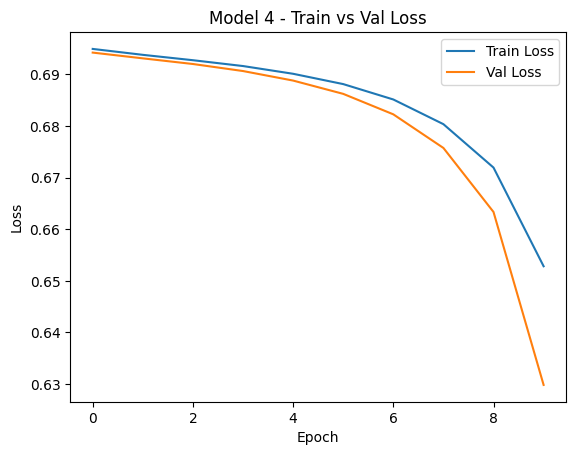

In [76]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 4 - Train vs Val Loss')
plt.show()

In [77]:
num_epochs = 10
criterion = nn.BCELoss()
optimizer = optim.SGD(model5.parameters(), lr=0.01)
train_losses, val_losses = train(model5, train_loader, valid_loader, criterion, optimizer, num_epochs)

Epoch [1/10], Train Loss: 0.6929, Val Loss: 0.6924
Epoch [2/10], Train Loss: 0.6922, Val Loss: 0.6917
Epoch [3/10], Train Loss: 0.6914, Val Loss: 0.6907
Epoch [4/10], Train Loss: 0.6903, Val Loss: 0.6892
Epoch [5/10], Train Loss: 0.6885, Val Loss: 0.6867
Epoch [6/10], Train Loss: 0.6854, Val Loss: 0.6822
Epoch [7/10], Train Loss: 0.6795, Val Loss: 0.6733
Epoch [8/10], Train Loss: 0.6671, Val Loss: 0.6537
Epoch [9/10], Train Loss: 0.6340, Val Loss: 0.5913
Epoch [10/10], Train Loss: 0.5054, Val Loss: 0.3691


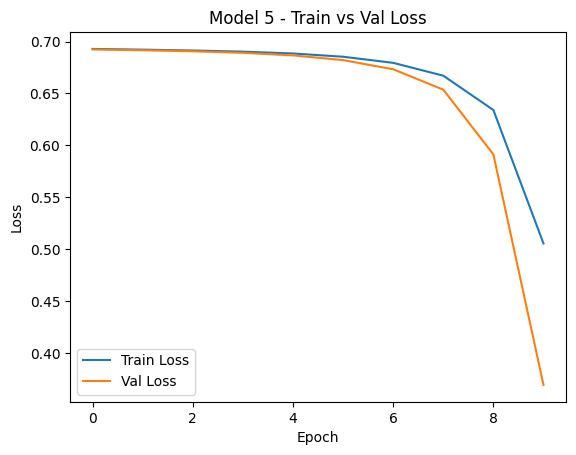

In [78]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model 5 - Train vs Val Loss')
plt.show()

In [79]:
def test(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    return y_true, y_pred


In [91]:
y_true, y_pred = test(model1, test_loader)

In [83]:
import seaborn as sns

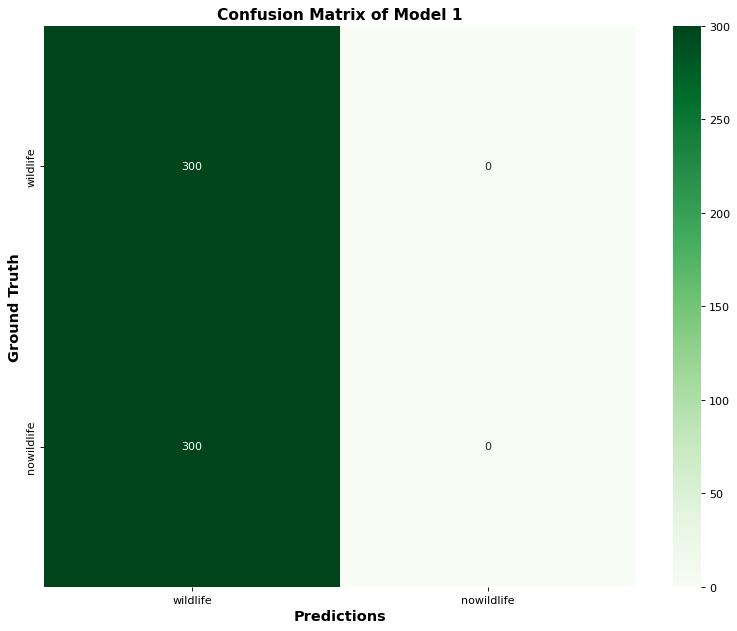

In [92]:
conf_arr = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['wildlife', 'nowildlife'], yticklabels= ['wildlife', 'nowildlife'])

plt.title('Confusion Matrix of Model 1', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

In [96]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=['wildlife', 'nowildlife']))

              precision    recall  f1-score   support

    wildlife       0.50      1.00      0.67       300
  nowildlife       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [97]:
y_true, y_pred = test(model2, test_loader)

In [98]:
print(classification_report(y_true, y_pred, target_names=['wildlife', 'nowildlife']))

              precision    recall  f1-score   support

    wildlife       0.50      1.00      0.67       300
  nowildlife       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

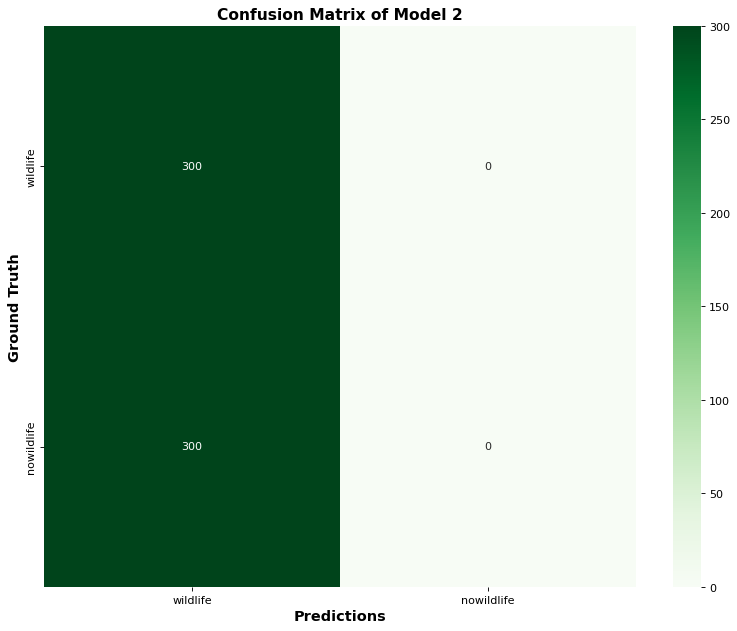

In [87]:
conf_arr = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['wildlife', 'nowildlife'], yticklabels= ['wildlife', 'nowildlife'])

plt.title('Confusion Matrix of Model 2', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

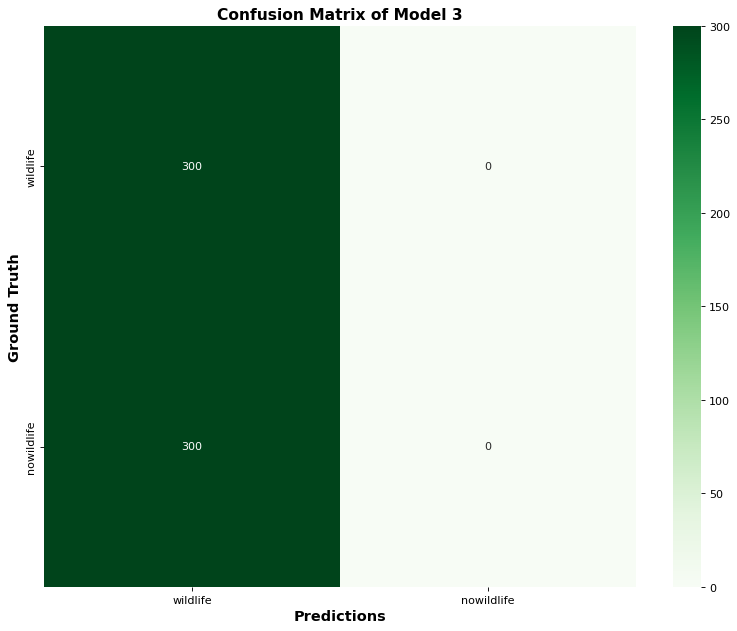

In [88]:
y_true, y_pred = test(model3, test_loader)
conf_arr = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['wildlife', 'nowildlife'], yticklabels= ['wildlife', 'nowildlife'])

plt.title('Confusion Matrix of Model 3', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

In [99]:
print(classification_report(y_true, y_pred, target_names=['wildlife', 'nowildlife']))

              precision    recall  f1-score   support

    wildlife       0.50      1.00      0.67       300
  nowildlife       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

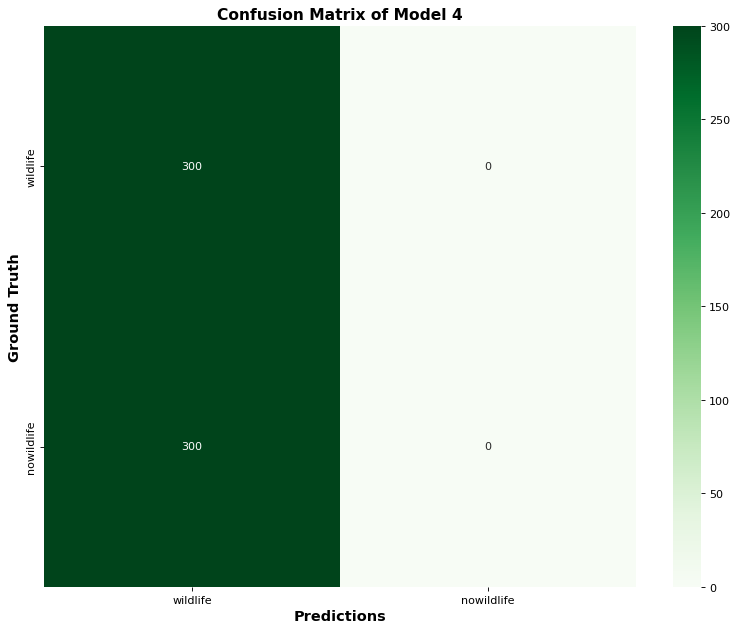

In [102]:
y_true, y_pred = test(model4, test_loader)
conf_arr = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['wildlife', 'nowildlife'], yticklabels= ['wildlife', 'nowildlife'])

plt.title('Confusion Matrix of Model 4', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

In [100]:
print(classification_report(y_true, y_pred, target_names=['wildlife', 'nowildlife']))

              precision    recall  f1-score   support

    wildlife       0.50      1.00      0.67       300
  nowildlife       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

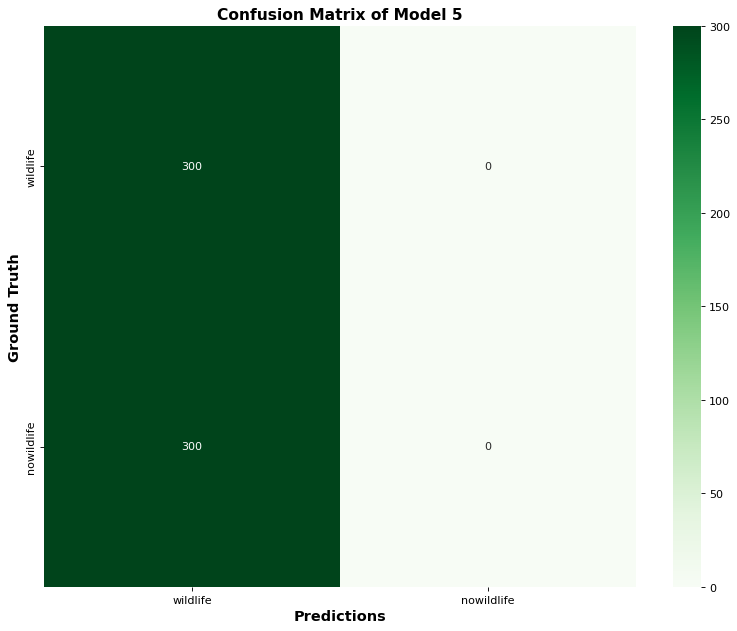

In [90]:
y_true, y_pred = test(model5, test_loader)
conf_arr = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels= ['wildlife', 'nowildlife'], yticklabels= ['wildlife', 'nowildlife'])

plt.title('Confusion Matrix of Model 5', fontweight='bold', fontsize=14.0)
plt.xlabel('Predictions', fontweight='bold', fontsize=13)
plt.ylabel('Ground Truth', fontweight='bold', fontsize=13)
plt.tight_layout()
plt.show(ax)

In [101]:
print(classification_report(y_true, y_pred, target_names=['wildlife', 'nowildlife']))

              precision    recall  f1-score   support

    wildlife       0.50      1.00      0.67       300
  nowildlife       0.00      0.00      0.00       300

    accuracy                           0.50       600
   macro avg       0.25      0.50      0.33       600
weighted avg       0.25      0.50      0.33       600



c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\zain4\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo